# DATASET EXPLORATION

This notebook contains all the functionality that allows us to explore the make-up and characteristics of a dataset.

In [1]:
"""
IMPORTS
"""
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from sklearn.manifold import TSNE
import fatf.fairness.data.measures as fatf_dfm

import fatf.utils.data.tools as fatf_data_tools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor


from utils.dataloader import DataLoader
from utils.constants import protected_attributes, group_proxies

24-Mar-30 20:25:40 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [2]:
"""
    CONFIGURE SEABORN STYLING
"""
sns.set(style='whitegrid')
sns.set_palette('bright')

In [3]:
"""
    LOAD DATASET
"""

dataloader = DataLoader()
X_train, y_train = dataloader.load_split('train')
print(f'{X_train.shape}, {y_train.shape}')
X_test, y_test = dataloader.load_split('test')
print(f'{X_test.shape}, {y_test.shape}')
X_data, y_data = dataloader.load_split('full')
print(f'{X_data.shape}, {y_data.shape}')

(10116, 315), (10116,)
(2529, 315), (2529,)
(12645, 315), (12645,)


In [4]:
"""
Config to set which dataset analys tools to use. True is yes, False is no.    
"""

config = {
    'describe': False,
}

In [5]:
"""
BASIC DATASET STATISTICS
"""

if config['describe'] == True:
    print(X_data.describe())
    

In [6]:
"""
PLOT LABEL DISTRIBUTIONS
"""

# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(y_data.value_counts()[0]/len(y_data) * 100,2), '% of the dataset')
print('Frauds', round(y_data.value_counts()[1]/len(y_data) * 100,2), '% of the dataset')

No Frauds 90.0 % of the dataset
Frauds 10.0 % of the dataset


In [7]:
conclusion_labels = """ The above shows the dataset is imbalanced. We should make up for it during training!
"""

In [8]:
"""
tSNE

CODE BASED ON https://www.kaggle.com/code/tilii7/dimensionality-reduction-pca-tsne
"""
colors = ['blue', 'red']
y = y_data.values.astype(np.int8)
target_name = 'checked'
run_tsne = False

if run_tsne == True:

    tsne = TSNE(n_components=2, init='pca', random_state=1001, perplexity=30, method='barnes_hut', n_iter=1000, verbose=1)
    X_tsne = tsne.fit_transform(X_data) # this will either fail or take a while (most likely overnight)

    plt.figure(2, figsize=(10, 10))

    for i, target_name in zip([0, 1], ['checked']):
        plt.scatter(X_tsne[y == i, 0], 
                    X_tsne[y == i, 1], 
                    color=colors[i],  # Pass the color based on class index
                    s=1, alpha=.8, label=target_name, marker='.')
    plt.legend(loc='best', shadow=False, scatterpoints=3)
    plt.title('Scatter plot of t-SNE embedding')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.savefig('t-SNE-porto-01.png', dpi=150)
    plt.show()

In [9]:
""" PLOT FEATURE DISTRIBUTIONS """
# Create a dropdown menu with all the features
feature_dropdown = widgets.Dropdown(
    options=X_data.columns,
    description='Feature:',
)

# Create a new output area for the plot
output = widgets.Output()

# Define a function to update the plot when a new feature or label is selected
def update_plot(feature, label, target_value=1):
    with output:
        clear_output(wait=True)  # Clear the current output

        # Create the scatter plot based on the chosen plot type
        plt.figure(figsize=(8, 6))  # Adjust figure size if needed
        plt.figure(figsize=(8, 6))  # Adjust figure size if needed
        sns.histplot(
            data=dataloader.dataset[dataloader.dataset['checked'] == target_value], x=feature, label=f"{label} = {target_value}", alpha=0.5
        )
        sns.histplot(
            data=dataloader.dataset[dataloader.dataset['checked'] != target_value], x=feature, label=f"{label} != {target_value}", alpha=0.5
        )
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {feature} by labels')
        # plt.legend()  # Show the legend for clarity
        plt.show()
# Display the dropdown menus and the initial plot
display(feature_dropdown)
display(output)

# Call the update_plot function when either dropdown is changed
feature_dropdown.observe(lambda change: update_plot(change.new, y_train), names='value')

Dropdown(description='Feature:', options=('adres_aantal_brp_adres', 'adres_aantal_verschillende_wijken', 'adre…

Output()

In [10]:
"""
    LINEAR REGRESSION 
"""

lr_model = LinearRegression() 
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
mae = np.mean(np.abs(y_test - y_pred))
print(f'mae: {mae}')


mae: 0.1855105719152386


Text(0, 0.5, 'Features')

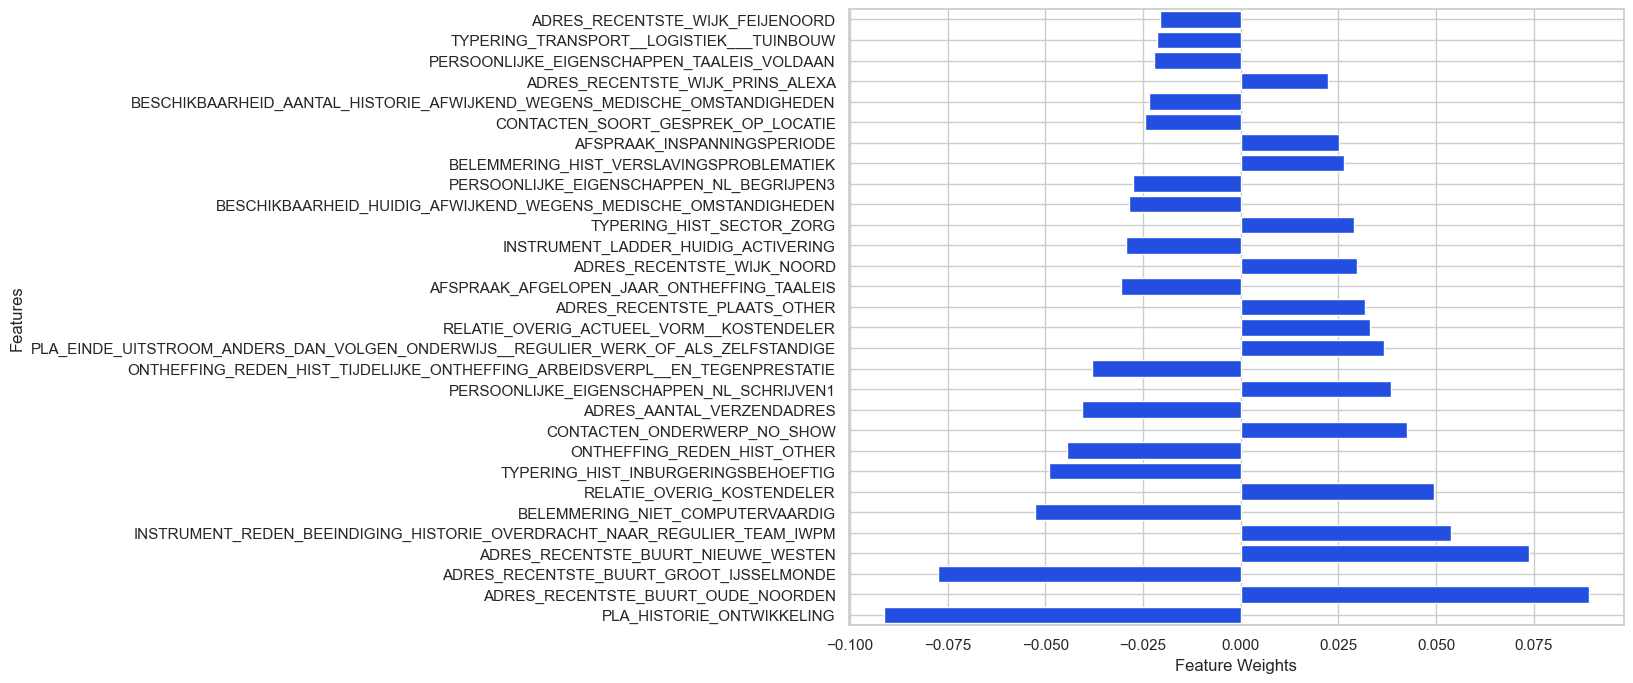

In [11]:
weights = lr_model.coef_

feature_importance_idx = np.argsort(np.abs(weights))[-30:]
feature_importance = [X_test.columns[idx].upper() for idx in
 feature_importance_idx] 
feature_importance_values = [weights[idx] for idx in
 feature_importance_idx]
f, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x=feature_importance_values, y=feature_importance, ax=ax) 
ax.grid(True) 
ax.set_xlabel('Feature Weights') 
ax.set_ylabel('Features') 

In [12]:
conclusion_lr = """
CONCLUSION LINEAR REGRESSION: The above shows that adres features have both increasing and decreasing affect on fraud prediction.
The relationship status also has a significant affect on the model outcome. 
As well as features related to medical or private circumstances. 
"""

In [13]:
"""
DTREE
"""

dt_model = DecisionTreeRegressor(max_depth=None, random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
mae = np.mean(np.abs(y_test - y_pred))
print(f'mae: {mae}')

mae: 0.1320680110715698


Text(0, 0.5, 'Features')

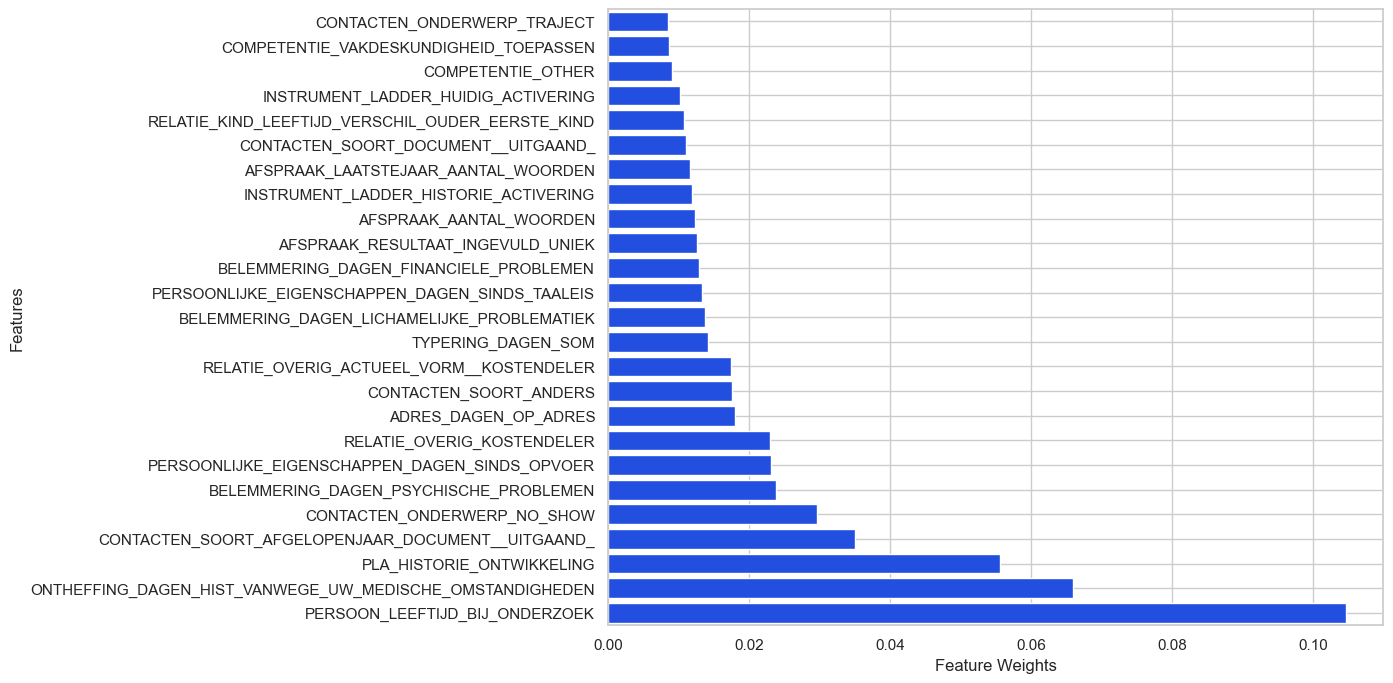

In [14]:
weights = dt_model.feature_importances_ #A
feature_importance_idx = np.argsort(np.abs(weights))[-25:] #B
feature_importance = [X_test.columns[idx].upper() for idx in
 feature_importance_idx] #C
feature_importance_values = [weights[idx] for idx in
 feature_importance_idx] #C
f, ax = plt.subplots(figsize=(10, 8)) #D
sns.barplot(x=feature_importance_values, y=feature_importance, ax=ax) #D
ax.grid(True) #D
ax.set_xlabel('Feature Weights') #D
ax.set_ylabel('Features') #D 

In [15]:
conclusion_dtree = """
CONCLUSION DECISION TREE: The decision trees bases its prediction significantly on the age of the person. 
Similarly to the LR, it bases it decision son adresses, relationship status, and medical/private circumstances.  
"""

In [16]:
"""
DATASET FAIRNESS
FROM: https://github.com/fat-forensics/fat-forensics/blob/master/examples/fairness/xmpl_fairness_data_measure.py
"""

run_bias_check = True

if run_bias_check == True:
    indices = [X_train.columns.get_loc(attr) for attr in group_proxies]
    # Compute the data fairness matrix
    data_fairness_matrix = fatf_dfm.systemic_bias(X_data.to_numpy(), y_data.to_numpy(), indices)

    # Check if the data set is unfair (at least one unfair pair of data points)
    is_data_unfair = fatf_dfm.systemic_bias_check(data_fairness_matrix)

In [17]:
# Identify which pairs of indices cause the unfairness
unfair_pairs_tuple = np.where(data_fairness_matrix)
unfair_pairs = []
for i, j in zip(*unfair_pairs_tuple):
    pair_a, pair_b = (i, j), (j, i)
    if pair_a not in unfair_pairs and pair_b not in unfair_pairs:
        unfair_pairs.append(pair_a)

# Print out whether the fairness condition is violated
if is_data_unfair:
    unfair_n = len(unfair_pairs)
    unfair_fill = ('is', '') if unfair_n == 1 else ('are', 's')
    print('\nThere {} {} pair{} of data points that violates the fairness '
          'criterion.\n'.format(unfair_fill[0], unfair_n, unfair_fill[1]))
else:
    print('The data set is fair.\n')

The data set is fair.



In [18]:
# Group the data based on the unique values of the 'gender' column
grouping_column = X_train.columns.get_loc('persoon_geslacht_vrouw')

grouping_indices, grouping_names = fatf_data_tools.group_by_column(
    X_train.to_numpy(), grouping_column, treat_as_categorical=True)

# Print out the data distribution for the grouping
print('The grouping based on the *{}* feature has the '
      'following distribution:'.format(grouping_column))
for grouping_name, grouping_idx in zip(grouping_names, grouping_indices):
    print('    * "{}" grouping has {} instances.'.format(
        grouping_name, len(grouping_idx)))

# Get the class distribution for each sub-grouping
grouping_class_distribution = dict()
for grouping_name, grouping_idx in zip(grouping_names, grouping_indices):
    print(grouping_name)
    sg_y = y_train[grouping_idx]
    sg_classes, sg_counts = np.unique(sg_y, return_counts=True)

    grouping_class_distribution[grouping_name] = dict()
    for sg_class, sg_count in zip(sg_classes, sg_counts):
        sg_class_name = 'checked'

        grouping_class_distribution[grouping_name][sg_class_name] = sg_count

# Print out the class distribution per sub-group
print('\nThe class distribution per sub-population:')
for grouping_name, class_distribution in grouping_class_distribution.items():
    print('    * For the "{}" grouping the classes are distributed as '
          'follows:'.format(grouping_name))
    for class_name, class_count in class_distribution.items():
        print('        - The class *{}* has {} data points.'.format(
            class_name, class_count))

The grouping based on the *215* feature has the following distribution:
    * "(0,)" grouping has 5244 instances.
    * "(1,)" grouping has 4872 instances.
(0,)
(1,)

The class distribution per sub-population:
    * For the "(0,)" grouping the classes are distributed as follows:
        - The class *checked* has 517 data points.
    * For the "(1,)" grouping the classes are distributed as follows:
        - The class *checked* has 479 data points.
